In [2]:
from timm.models.vision_transformer import VisionTransformer
import torch.nn as nn


class SimCLRViT(VisionTransformer):
    def __init__(self, device="cuda"):
        super().__init__(
            img_size=28,
            patch_size=4,
            in_chans=1,
            num_classes=10,
            embed_dim=64,
            depth=4,
            num_heads=4,
            mlp_ratio=4,
            norm_layer=nn.LayerNorm,
            device=device,
        )

In [ ]:
import torch
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt
import numpy as np
from model import DinoViT
from timm.utils.attention_extract import AttentionExtract
from timm.layers import set_fused_attn
from PIL.Image import Image
import torch.nn.functional as F

# -----------------------------
# 1. Load a FashionMNIST image
# -----------------------------
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)
image, label = dataset[10]

# Add batch dimension
img_batch = image.unsqueeze(0)

# -----------------------------
# 2. Load ViT model from timm
# -----------------------------
# vit_base_patch16_224 is standard pretrained ViT
set_fused_attn(False)
dino_model = DinoViT(device="cuda")
dino_model.load_state_dict(torch.load("DINO_ViT_simple_head.pth"))
dino_model.eval()
simclr_model = SimCLRViT(device='cuda')
simclr_model.load_state_dict(torch.load("../lab2/ViT-simCLR.pth"))
simclr_model.head = nn.Identity()

with torch.no_grad():
    sim_clr_extractor = AttentionExtract(simclr_model)

with torch.no_grad():
    dino_extractor = AttentionExtract(dino_model)

dino_attention_maps = dino_extractor(img_batch.to("cuda"))
simclr_attention_maps = sim_clr_extractor(img_batch.to("cuda"))

patch_id_attendance = 0  # 0 for cls token
patch_width = 7
patch_height = 7

for block, attn_maps in reversed(dino_attention_maps.items()):
    for head_id, attn_map in enumerate(attn_maps[0]):
        attn_map = attn_map[patch_id_attendance, 1:].reshape(7, 7)
        resized_map = F.interpolate(
            attn_map.unsqueeze(0).unsqueeze(0), size=(28, 28)
        ).squeeze(0)
        resized_map = (resized_map - resized_map.min()) / (
            resized_map.max() - resized_map.min()
        )
        image_preview = ((image + 1) / 2)
        resized_map = resized_map.permute(1, 2, 0).detach().cpu().numpy()
        image_preview = image_preview.permute(1, 2, 0)

        plt.figure(figsize=(6,6))
        plt.imshow(image_preview, cmap='gray')
        plt.imshow(resized_map, alpha=resized_map.squeeze(2))
        plt.axis('off')
        plt.title(f"{block}: head #{head_id}")
        plt.show()

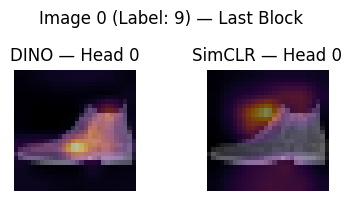

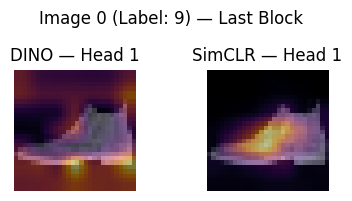

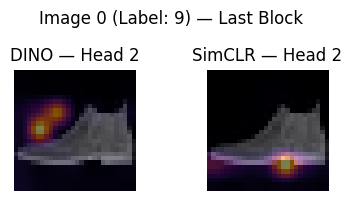

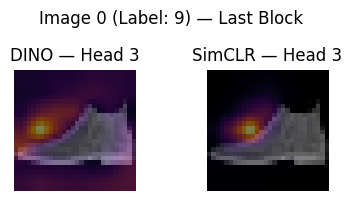

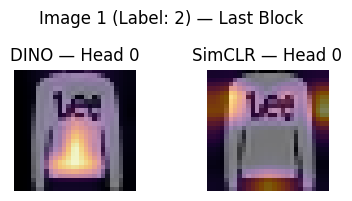

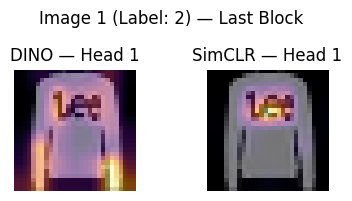

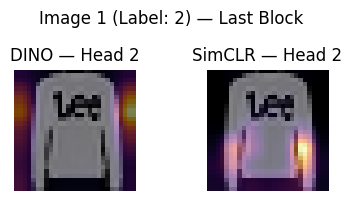

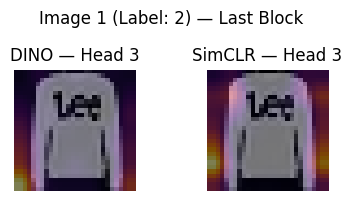

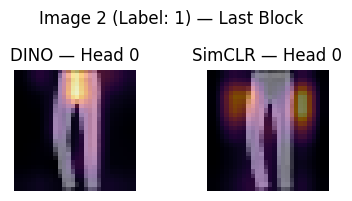

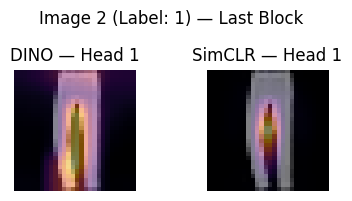

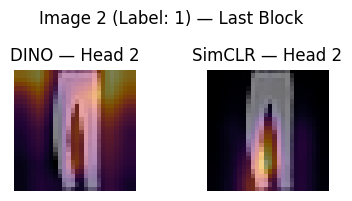

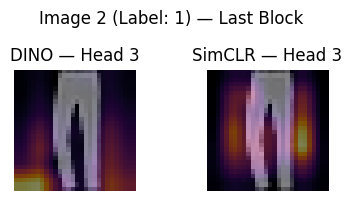

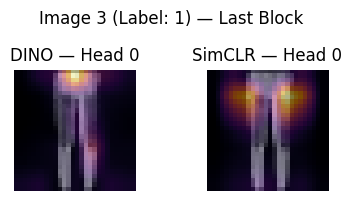

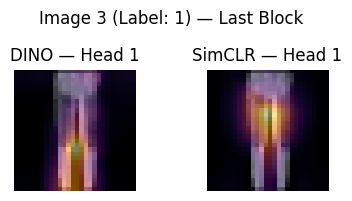

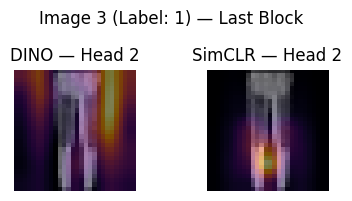

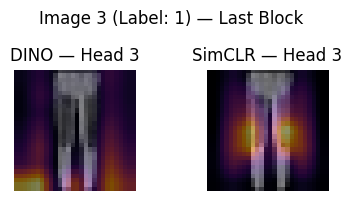

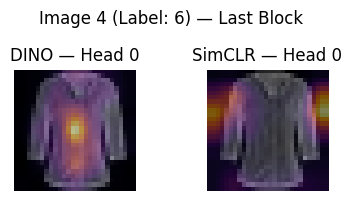

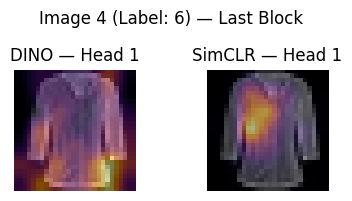

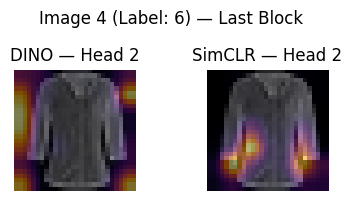

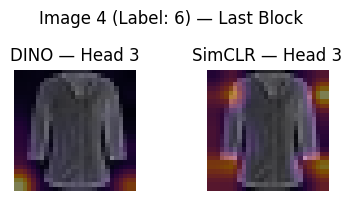

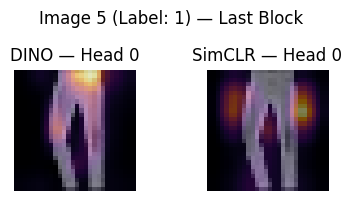

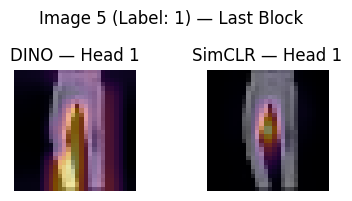

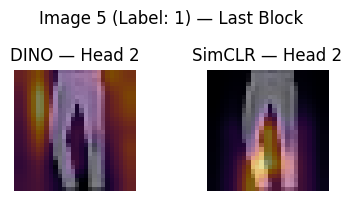

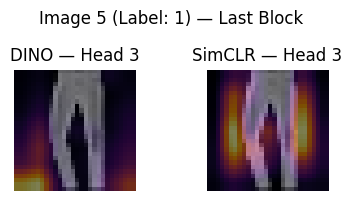

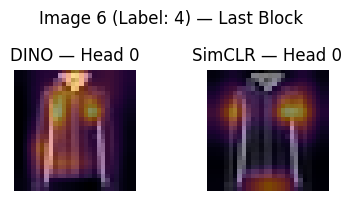

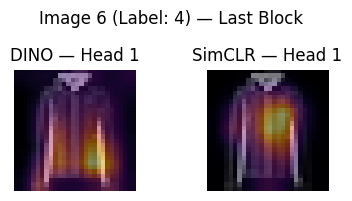

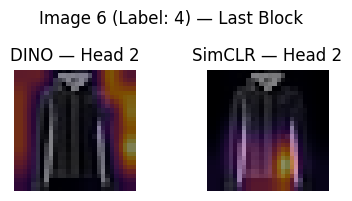

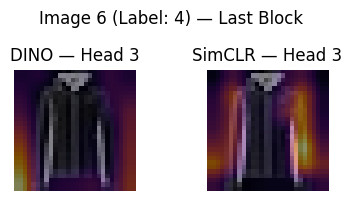

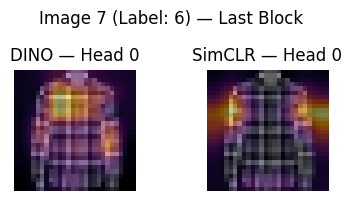

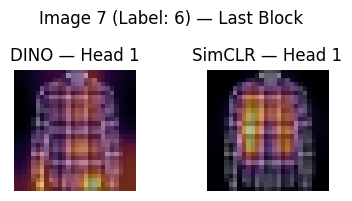

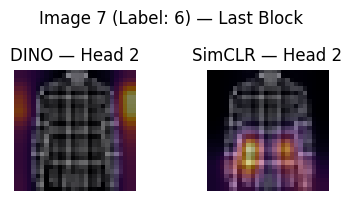

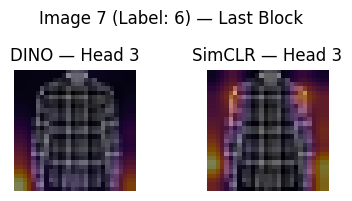

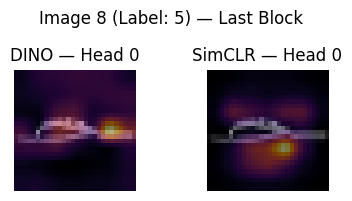

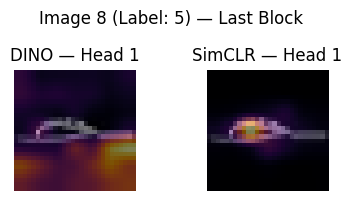

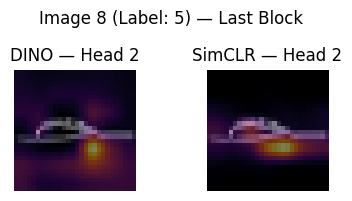

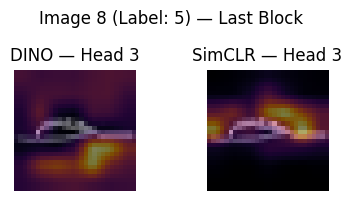

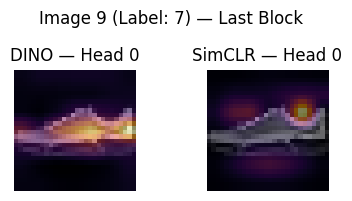

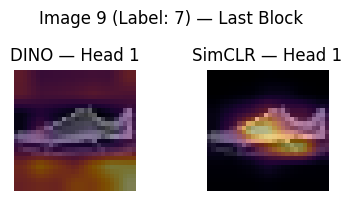

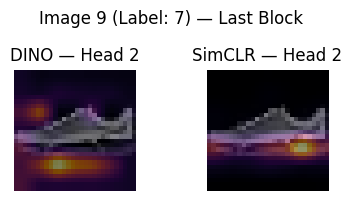

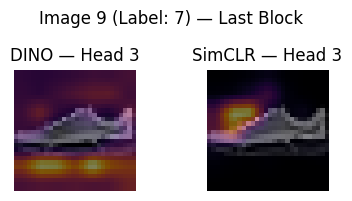

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from timm.utils.attention_extract import AttentionExtract
from timm.layers import set_fused_attn
from model import DinoViT
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 1. Dataset and transforms
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

# Take first 10 samples
samples = [dataset[i] for i in range(10)]

# -----------------------------
# 2. Load models
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
set_fused_attn(False)

dino_model = DinoViT(device=device).to(device)
dino_model.load_state_dict(torch.load("DINO_ViT_simple_head.pth", map_location=device))
dino_model.eval()

simclr_model = SimCLRViT(device=device).to(device)
simclr_model.load_state_dict(torch.load("../lab2/ViT-simCLR.pth", map_location=device))
simclr_model.head = nn.Identity()
simclr_model.eval()

# -----------------------------
# 3. Create attention extractors
# -----------------------------
with torch.no_grad():
    dino_extractor = AttentionExtract(dino_model)
    simclr_extractor = AttentionExtract(simclr_model)

# -----------------------------
# 4. Visualization loop
# -----------------------------
patch_size = 7  # 7x7 patches for 224x224 model
for idx, (image, label) in enumerate(samples):
    img_batch = image.unsqueeze(0).to(device)

    # Extract attention maps
    with torch.no_grad():
        dino_attn = dino_extractor(img_batch)
        simclr_attn = simclr_extractor(img_batch)

    # Take last block only
    last_block = list(dino_attn.keys())[-1]
    dino_last = dino_attn[last_block][0]
    simclr_last = simclr_attn[last_block][0]

    # Visualize for 4 heads
    for head_id in range(4):
        fig, axs = plt.subplots(1, 2, figsize=(4, 2))

        for j, (maps, title) in enumerate([
            (dino_last, "DINO"), 
            (simclr_last, "SimCLR")
        ]):
            attn_map = maps[head_id][0, 1:].reshape(patch_size, patch_size)
            attn_map = F.interpolate(
                attn_map.unsqueeze(0).unsqueeze(0),
                size=(28, 28),
                mode="bilinear",
                align_corners=False
            ).squeeze()

            attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

            image_preview = ((image + 1) / 2).squeeze(0).cpu().numpy()
            ax = axs[j]
            ax.imshow(image_preview, cmap="gray")
            ax.imshow(attn_map.cpu().numpy(), alpha=0.5, cmap="inferno")
            ax.axis("off")
            ax.set_title(f"{title} — Head {head_id}")

        plt.suptitle(f"Image {idx} (Label: {label}) — Last Block")
        plt.tight_layout()
        plt.show()
